## Project 2: Black and White Colorization

### Section 1: Loading and modifying dataset

#### Helper functions

In [1]:
import cv2
import os
import glob
import torch
import numpy as np
from matplotlib import pyplot as plt
import torchvision.transforms as T

torch.set_default_tensor_type('torch.FloatTensor') #Sets default tensor value to float
 
def loadImgsToList():
    img_dir = "./AllImages/face_images/*.jpg" #Function which loads in the face images and returns a list containing RGB values, as well as the number of images read
    files = sorted(glob.glob(img_dir))

    data = []
    numImages = 0
    for f1 in files:
        image = cv2.imread(f1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #cv2 stores colors as BGR instead of RGB for some reason     
        data.append(image)
        numImages += 1 #probably unnecessary but I like to avoid using len() for arrays/lists of multiple dimensions
    
    return data, numImages #Capture return as array, number = loadImgsToList()
   
def createTensor(data, numImages): #Function to create an Tensor from a data list, data is unshuffled and unedited from raw
    shape = (numImages, 128, 128, 3) #Shape of the tensor = (number of images, height, width, number of channels), it was recommended online to do it in this order
    tempTensor = torch.zeros(shape) #Populate empty tensor of correct size

    count = 0
    for i in data:
        curData = torch.from_numpy(data[count]) #converts 
        tempTensor[count] = curData
        count += 1
    
    return tempTensor

def shuffleTensor(tempTensor, numImages):
    perm = torch.randperm(numImages) #Gives an array which is a permutation of the numbers [0:numImages] EG: 0, 1, 2, 3 can become 0, 3, 1, 2
    shape = (numImages, 128, 128, 3) 
    
    rgbTensor = torch.zeros(shape) #holder
    for i in perm: #set holder value to its permutated counterpart
        rgbTensor[i] = tempTensor[perm[i]]
    
    return rgbTensor

def randomCrop(inputTensor):
    length = np.random.randint(70,115) #crop size, minimum image size after crop is 70x70, max is 115x115, arbitrary and can/should be adjusted
    randCrop = T.RandomCrop(size = (length, length))
    resized = T.Resize(size = (128, 128)) #resizes images to 128x128
    tempTensor = inputTensor.permute(2, 0, 1) #because randomcrop doesn't like the 3 at the end
    tempTensor = resized(randCrop(tempTensor))
    tempTensor = tempTensor.permute(1, 2, 0) #fixing the other permute
    return tempTensor

def horizontalFlip(inputTensor):
    return torch.fliplr(inputTensor) #convenient built in

def scaleRGBValues(inputTensor):
    scalar = np.random.uniform(.6, 1)
    return inputTensor * scalar #This was way too complicated before

def populateAndScaleDataset(data, numImages, scaleFactor, saveTensor):
    myTensor = createTensor(data, numImages) #Create and shuffle a tensor from the loaded in data
    #myTensor = shuffleTensor(myTensor, numImages)
    
    newShape = (scaleFactor*numImages, 128, 128, 3) #Create a holder for the new, scaled Tensor
    newTensor = torch.zeros(newShape)
    
    count = 0 #horizontal counter
    for i in range(numImages): #for each data image
        for j in range(scaleFactor): #make {scaleFactor} more
            if j == 0: #Include the original
                newTensor[count] = myTensor[i]
            else: #else, randomly change the rest
                tempTensor = myTensor[i] #initialize to original
                
                val1 = np.random.uniform(0, 1) #rand val between 0 and 1
                if val1 >= .5: #half of the time, flip it
                    tempTensor = horizontalFlip(tempTensor)
                
                val2 = np.random.uniform(0, 1)
                if val2 >= .5: #half of the time, crop it
                    tempTensor = randomCrop(tempTensor)
                    
                val3 = np.random.uniform(0, 1)
                if val3 >= .5: #half of the time, scale it
                    tempTensor = scaleRGBValues(tempTensor)
            
                newTensor[count] = tempTensor #add it to the holder
            count += 1    #increment count
            
            #NOTE: obviously, the values for when to alter the new images can be adjusted. It's done this way so that multiple transformations can be done on one image
            # Has the flaw of sometimes repeating images, which may be bad for the dataset. Can be easily fixed by adding a default case at the end, but I have omitted that for now
            
    if saveTensor:
        x = "000000" 
        for i in range(len(newTensor)):
            filename = r"./AllImages/augmented/rgb_image" + x + ".jpg"
            x =  str(int(x) + 1).zfill(len(x)) #maintains 6 digits at end

            img = newTensor[i].numpy()
            cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #convert to BGR so cv2 can save it
            s = cv2.imwrite(filename, img)

            if not s:
                print(s) #print failure

    return newTensor

def convertToLab(mytensor, saveTensor):
    holderTensor = torch.zeros(mytensor.shape) #holder tensor to return
    
    x = "000000" #used in filenames
    for i in range(len(mytensor)):
        test = cv2.cvtColor(mytensor[i].numpy()/255.0, cv2.COLOR_RGB2Lab) #actual conversion
        holderTensor[i] = torch.from_numpy(test) #save to holder
        
        if saveTensor:
            filenameL = r"./AllImages/L/L_image" + x + ".jpg" #initialize filenames
            filenameA = r"./AllImages/a/a_image" + x + ".jpg"
            filenameB = r"./AllImages/b/b_image" + x + ".jpg"
            x =  str(int(x) + 1).zfill(len(x)) #maintains 6 digits at end and increments x

            L, a, b = cv2.split(test) #split L, a, and b
            L_s = cv2.imwrite(filenameL, L) #and save them
            a_s = cv2.imwrite(filenameA, a)
            b_s = cv2.imwrite(filenameB, b)

            if not L_s or not a_s or not b_s :
                print(L_s, a_s, b_s) #print failure
            
    return holderTensor

def displayImage(data):
    image = data
    #Show the image with matplotlib
    plt.imshow(image/255)
    plt.show()

#### Call data initialization functions

In [2]:
#Initialize dataset, scale it
data, numImgs = loadImgsToList()
sf = 10


origTensor = createTensor(data, numImgs)
origLabTensor = convertToLab(origTensor, False) #KEEP FALSE
scaledTensor = populateAndScaleDataset(data, numImgs, sf, False)

In [3]:
scaledLabTensor = convertToLab(scaledTensor, False) #convert color space (prev 2 functions also save files)

In [4]:
dataset = shuffleTensor(scaledLabTensor, numImgs*sf) #Shuffle after saving to preserve order in files (cataloging purposes)

### Regressor Section

In [5]:
import torch.nn as nn
import torch.nn.functional as F

def getMeanChrominance(a, b):
    aCount = 0
    bCount = 0
    num = 0
    
    a_ = a.numpy()
    b_ = b.numpy()
    
    for i in range(len(a_)):
        for j in range(len(a_[0])):
            aCount += a_[i][j][0]
            bCount += b_[i][j][0]
            num += 1
    return aCount/num, bCount/num

def splitChannelsAsTensors(dataset):
    L = torch.zeros((len(dataset), 128, 128))
    a = torch.zeros((len(dataset), 128, 128))
    b = torch.zeros((len(dataset), 128, 128))
    
    dataset = dataset.permute(0, 3, 1, 2)
    
    for i in range(len(dataset)):
        L[i] = dataset[i][0]/100
        a[i] = dataset[i][1]/128
        b[i] = dataset[i][2]/128
 
    L = L.reshape(len(dataset), 128, 128, 1)
    a = a.reshape(len(dataset), 128, 128, 1)
    b = b.reshape(len(dataset), 128, 128, 1)

    return L, a, b

def getAverageFromTensor(tensor):
    temp = torch.flatten(tensor.detach()).numpy()
        
    count = 0
    num = len(temp)
    for i in range(num):
        count += temp[i]
    
    avg = (count)/num
    return avg

def runNetwork(dataset):
    
    net = nn.Sequential(
            nn.Conv2d(1, 3, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(3, 3, 3, stride=2, padding=1),
        )
    
    dataL, dataA, dataB = splitChannelsAsTensors(dataset)
   
    meanA, meanB = getMeanChrominance(dataA[0], dataB[0])
    print("Mean Chrominance from A = ", meanA)
    print("Mean Chrominance from B = ", meanB)
    
    dataL = dataL.reshape(7500, 1, 1, 128, 128)
    
    result = net(dataL[0])
    print("Predicted mean chrominance from L = ", getAverageFromTensor(result))
    
    return result

In [6]:
result = runNetwork(dataset)

Mean Chrominance from A =  0.06522797793149948
Mean Chrominance from B =  0.06520760804414749
Predicted mean chrominance from L =  -0.08869472984224558


## Generating an Image and Training the model

In [23]:
net = nn.Sequential(
        nn.Conv2d(1, 128, 3, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 128, 3, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 8, 4, stride=2, padding=1),
        nn.BatchNorm2d(8),
        nn.Tanh(),
        nn.ConvTranspose2d(8, 2, 4, stride=2, padding=1),
        nn.BatchNorm2d(2)
    )

dataL, dataA, dataB = splitChannelsAsTensors(dataset)

dataL = dataL.reshape(7500, 1, 1, 128, 128)

result = net(dataL[0])

result = result

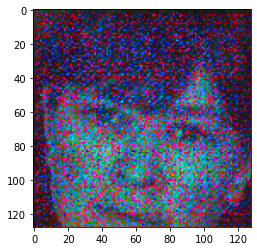

In [24]:
newA = torch.zeros((1, 128, 128))
newB = torch.zeros((1, 128, 128))
newL = torch.zeros((1, 128, 128))

newA = result[0][0][:][:].detach().reshape(1, 128, 128)*128
newB = result[0][1][:][:].detach().reshape(1, 128, 128)*128
newL = dataL[0][0][0][:][:].reshape(1, 128, 128)*100

newA = newA.permute(1, 2, 0).numpy()
newB = newB.permute(1, 2, 0).numpy()
newL = newL.permute(1, 2, 0).numpy()

newImage = cv2.merge((newL, newA, newB))
newImage = cv2.cvtColor(newImage, cv2.COLOR_LAB2RGB)*255


displayImage(newImage)

## Training

In [25]:
net.train()

print(scaledLabTensor.shape)

def createBatchedDataset(tensorToBatch, numInBatch):
    newLen = len(tensorToBatch)//numInBatch
    size = (newLen, numInBatch, 1, 128, 128)
    #(750, 10, 1, 128, 128)
        
    tensorToReturn = torch.zeros(size)
    
    for i in range(newLen):
        for j in range(numInBatch):
            num = (i * numInBatch) + j
            tensorToReturn[i][j] = tensorToBatch[num][0]
            
    return tensorToReturn

torch.Size([7500, 128, 128, 3])


In [26]:
L, a, b = splitChannelsAsTensors(scaledLabTensor) #7500, augmented images

L = L.reshape(7500, 1, 1, 128, 128)
a = a.reshape(7500, 1, 1, 128, 128)
b = b.reshape(7500, 1, 1, 128, 128)

Lbatch = createBatchedDataset(L, 10)
abatch = createBatchedDataset(a, 10)
bbatch = createBatchedDataset(b, 10)

Ltrain = Lbatch[:675][:][:][:][:]
atrain = abatch[:675][:][:][:][:]
btrain = bbatch[:675][:][:][:][:]

ytrain = torch.cat((atrain, btrain), 2)

print(Ltrain.shape)

torch.Size([675, 10, 1, 128, 128])


In [27]:
lossfunc = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = .003)

print("img #: | MSE:")
for i in range(len(Ltrain)):
    ypred = net(Ltrain[i])    
    loss = lossfunc(ypred, ytrain[i])
    
    if i % 25 == 0:
        print(i*10, loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print("6749", loss.item())

img #: | MSE:
0 1.0084514617919922
250 0.8204187154769897
500 0.6766079664230347
750 0.6064279079437256
1000 0.4839693605899811
1250 0.41400057077407837
1500 0.319582462310791
1750 0.25103336572647095
2000 0.22298800945281982
2250 0.18652388453483582
2500 0.13148346543312073
2750 0.10610158741474152
3000 0.07552307844161987
3250 0.057687900960445404
3500 0.047485895454883575
3750 0.03533489257097244
4000 0.0302120354026556
4250 0.022736646234989166
4500 0.014770075678825378
4750 0.010640574619174004
5000 0.00984929408878088
5250 0.0060591972433030605
5500 0.005052056163549423
5750 0.0033275955356657505
6000 0.0022087586112320423
6250 0.0017079297685995698
6500 0.0014111388009041548
6749 0.0021952807437628508


In [28]:
net.eval()

# time to evaluate

L, a, b = splitChannelsAsTensors(origLabTensor) #750 original, unaugmented images

Ltest = L[675:][:][:][:]
Ltest = Ltest.permute(0, 3, 1, 2) #put bit in correct place

Ltest = Ltest.reshape((75, 1, 1, 128, 128))

atest = a[675:][:][:][:]
atest = atest.permute(0, 3, 1, 2)

btest = b[675:][:][:][:]
btest = btest.permute(0, 3, 1, 2)

ytest = torch.cat((atest, btest), 1)
ytest = ytest.reshape((75, 1, 2, 128, 128))


testloss = torch.nn.MSELoss()

lossArr = []
for i in range(len(Ltest)):
    ypred = net(Ltest[i])    
    
    loss = testloss(ypred, ytest[i])
    lossArr.append(loss.item())

avgLoss = sum(lossArr)/len(lossArr)

print("Avg Mean Squared Error:", avgLoss)

Avg Mean Squared Error: 0.002151113832369447


In [32]:
image = net(Ltest[10])

temp = image[0][0][:][:]

image[0][0][:][:] = image[0][1][:][:]
image[0][1][:][:] = temp


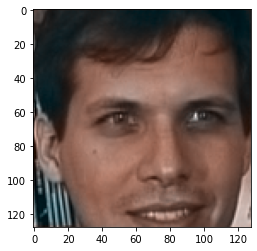

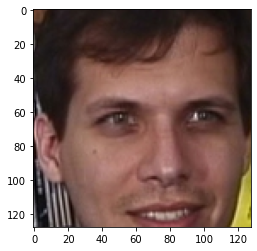

In [33]:
newA = torch.zeros((1, 128, 128))
newB = torch.zeros((1, 128, 128))
newL = torch.zeros((1, 128, 128))

newAB = image[0][:][:][:].detach().reshape(2, 128, 128)*128
newL = Ltest[10][0][:][:].reshape(1, 128, 128)*100

newAB = newAB.permute(1, 2, 0).numpy()
newL = newL.permute(1, 2, 0).numpy()

newImage = cv2.merge((newL, newAB))
newImage = cv2.cvtColor(newImage, cv2.COLOR_LAB2RGB)*255

displayImage(newImage)

oldImage = scaledLabTensor[6850].numpy()
oldImage = cv2.cvtColor(oldImage, cv2.COLOR_LAB2RGB)*255
displayImage(oldImage)